In [44]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

from causallearn.utils.GraphUtils import GraphUtils

In [4]:
# Lecture 2 synthetic data

def observed(n=100, c_dim=6, ols="y ~ a"):
    """
    The observed data distribution
      C: roll a k-sided die and record the result
      A: flip `1 + k - C` fair coins, and record 1 if at least one flip lands heads
      Y: flip `C + A` fair coins, and record the number of heads
    """

    c = np.random.randint(1, 1 + c_dim, n)
    a_tmp = np.random.binomial(n=1 + c_dim - c, p=0.5, size=n)
    a = (a_tmp > 0).astype(np.int32)
    y = np.random.binomial(n=a + c, p=0.5)

    df = pd.DataFrame(data=dict(c=c, a=a, y=y))
    return df


def randomized(n=100, c_dim=6, ols="y ~ a"):
    """
    The same distribution, except A is replaced with a fair coin f
      C: roll a k-sided die and record the result
      A: flip a single fair coin, and record 1 if it lands heads
      Y: flip `C + A` fair coins, and record the number of heads
    """

    c = np.random.randint(1, 1 + c_dim, n)
    a = np.random.binomial(n=1, p=0.5, size=n)
    y = np.random.binomial(n=a + c, p=0.5)

    df = pd.DataFrame(data=dict(c=c, a=a, y=y))
    return df

In [30]:
# Homework 2 synthetic data
def default_args():
    return dict(
        m_nonlinear=False,
        randomize=False,
        n=1000,

        c_var=0.02,
        a_dim=6,
        m_mean=100,
        m_var=1,

        #        C     D    A
        y_mean=[-200, -200, 4],
        y_int=200,
        y_var=1,
    )


def sample_data(**kwargs):
    """
    Sample a dataset from the given arguments.
    """

    np.random.seed(42)

    args = default_args()
    args.update(kwargs)

    m_nonlinear = args["m_nonlinear"]
    randomize = args["randomize"]
    n = args["n"]
    a_dim = args["a_dim"]

    # C is Gaussian
    c = np.random.normal(0, args["c_var"], size=[n, 1])
    # D is Binary
    d = np.random.randint(0, 2, n)

    if randomize:
        # A is fully randomized
        a = np.random.randint(0, a_dim, n)
    else:
        # Sample A conditional on C and D
        plusminus = np.power(-1, (np.arange(a_dim) < a_dim // 2).astype(int))
        probs = np.ones([1, a_dim]) / a_dim + c * plusminus
        probs = np.stack([probs for _ in range(2)], axis=1)

        thresholds = np.random.uniform(0, 1, size=[n, 2, 1])
        a = np.argmax(thresholds < np.cumsum(probs, axis=2), axis=2)
        a *= np.stack([np.ones(n, dtype=int), d], axis=1)
        a = np.max(a, axis=1)

    # Sample M conditional on A
    m_mean = args["m_mean"]
    m_var = args["m_var"]
    if m_nonlinear:
        b = (a + 1) / (1 + a_dim)
        m = np.random.normal(loc=m_mean * (1.05 * b - np.power(b, 2)),
                             scale=m_var, size=n)
    else:
        m = np.random.normal(loc=m_mean * (a + 1) / (a_dim + 1), scale=m_var, size=n)

    # Sample Y conditional on Y, C, D, and M
    c = c.reshape(n)
    y_mean = np.array(args["y_mean"])
    y = np.random.normal(np.dot(y_mean, (c, d, m)), args["y_var"])
    y += args["y_int"]

    df = pd.DataFrame(data=dict(c=c, d=d, a=a, m=m, y=y))

    return df

In [59]:
from causallearn.search.ConstraintBased.PC import pc

tests = [
    "fisherz", "chisq", "gsq", "kci", "mv_fisherz"
]

for test in tests:
    print(test)
    df = observed(n=1000)
    cg = pc(df.to_numpy(), indep_test=test, node_names=df.columns)
    print(cg.G)
#     cg.draw_pydot_graph(labels=df.columns )

fisherz


  0%|          | 0/3 [00:00<?, ?it/s]

Graph Nodes:
c;a;y

Graph Edges:
1. c --- a
2. c --- y
3. a --- y

chisq


  0%|          | 0/3 [00:00<?, ?it/s]

Graph Nodes:
c;a;y

Graph Edges:
1. c --- a
2. c --- y
3. a --- y

gsq


  0%|          | 0/3 [00:00<?, ?it/s]

Graph Nodes:
c;a;y

Graph Edges:
1. a --> c
2. y --> c

kci


  0%|          | 0/3 [00:00<?, ?it/s]

Graph Nodes:
c;a;y

Graph Edges:
1. c --- a
2. c --- y
3. a --- y

mv_fisherz


  0%|          | 0/3 [00:00<?, ?it/s]

Graph Nodes:
c;a;y

Graph Edges:
1. c --- a
2. c --- y
3. a --- y



fisherz


  0%|          | 0/5 [00:00<?, ?it/s]

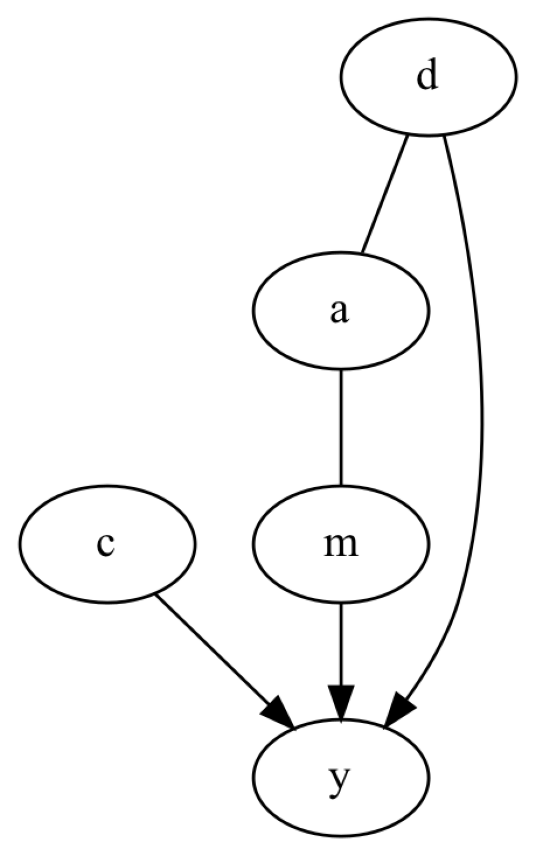

chisq


  0%|          | 0/5 [00:00<?, ?it/s]

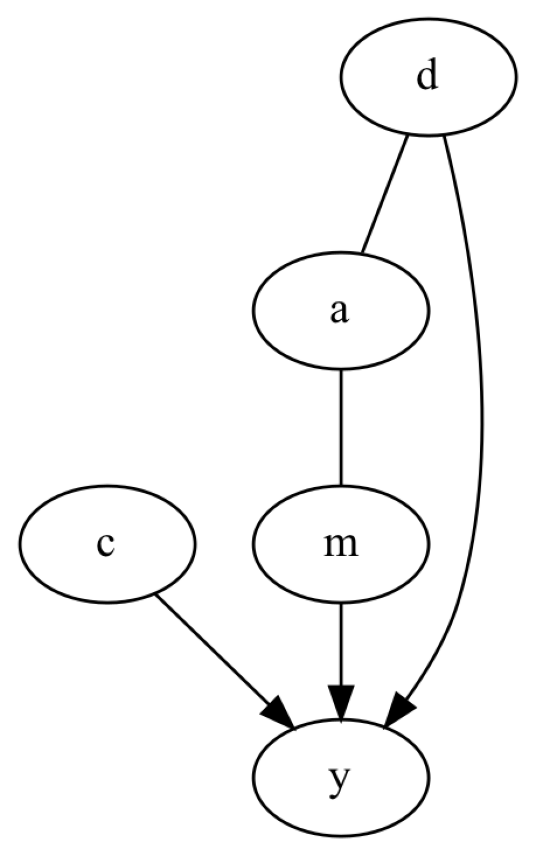

gsq


  0%|          | 0/5 [00:00<?, ?it/s]

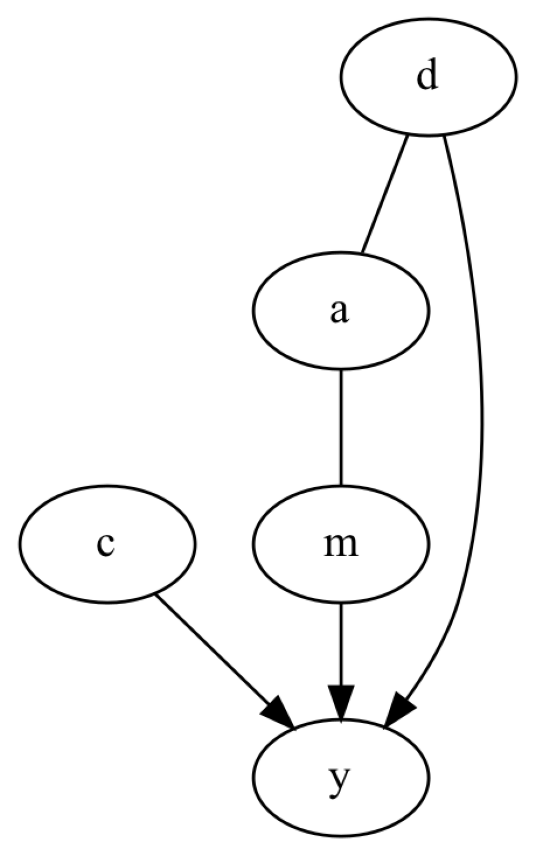

kci


  0%|          | 0/5 [00:00<?, ?it/s]

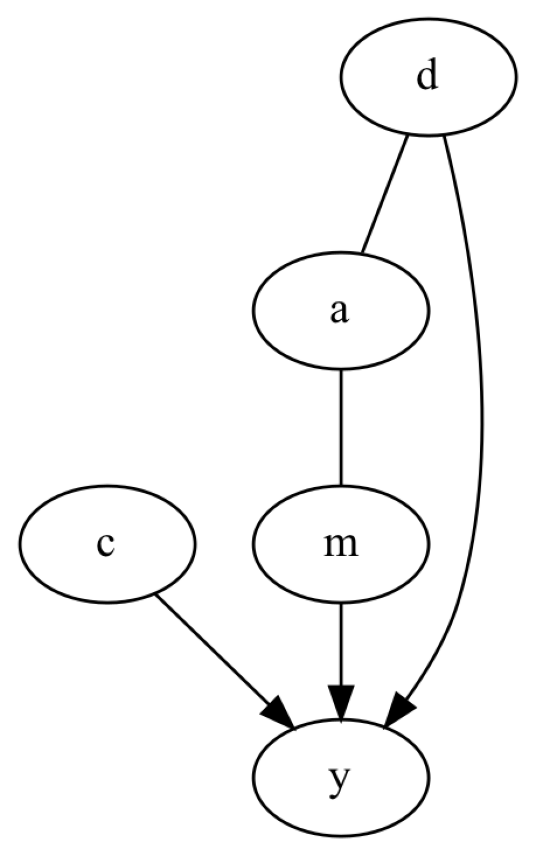

mv_fisherz


  0%|          | 0/5 [00:00<?, ?it/s]

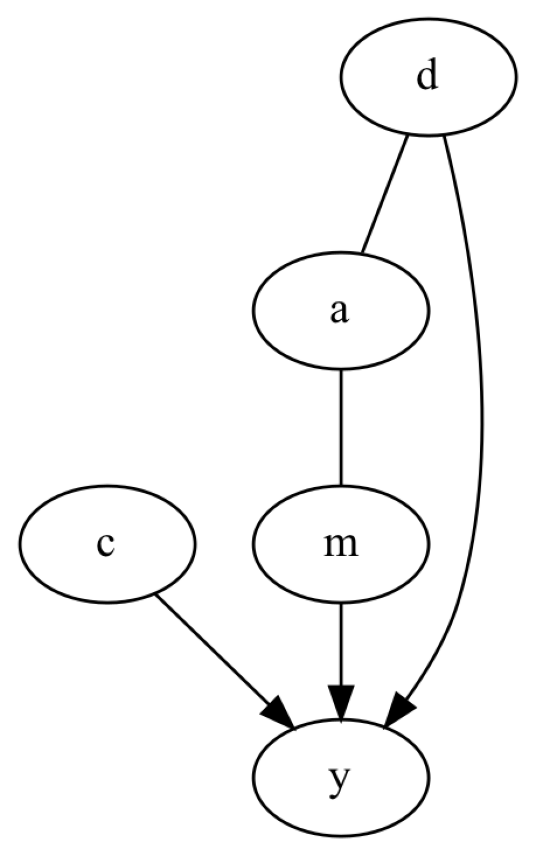

In [57]:
from causallearn.search.ConstraintBased.FCI import fci

tests = [
    "fisherz", "chisq", "gsq", "kci", "mv_fisherz"
]

args = default_args()
args["n"] = 1000
df = sample_data(**args)

for test in tests:
    print(test)
    cg, edges = fci(df.to_numpy(), indep_test=test, alpha=0.001, node_names=df.columns)
    pdy = GraphUtils.to_pydot(cg, labels=df.columns)
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [ ]:
from causallearn.search.ScoreBased.GES import ges

args = default_args()
df = sample_data(**args)

# df = randomized(n=1000)

Record = ges(df)

pyd = GraphUtils.to_pydot(Record['G'], labels=df.columns)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()


[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  1  0]
 [ 0  0 -1  0  0]
 [ 0  0  0  0  0]]
[[ 0  0  0  0  0]
 [ 0  0  0  0 -1]
 [ 0  0  0 -1  0]
 [ 0  0 -1  0  0]
 [ 0  1  0  0  0]]
[[ 0  0  0  0  0]
 [ 0  0  0  0 -1]
 [ 0  0  0 -1  0]
 [ 0  0 -1  0 -1]
 [ 0  1  0  1  0]]
[[ 0  0  0  0 -1]
 [ 0  0  0  0 -1]
 [ 0  0  0 -1  0]
 [ 0  0 -1  0 -1]
 [ 1  1  0  1  0]]
[[ 0  0  0  0 -1]
 [ 0  0 -1  0 -1]
 [ 0  1  0 -1  0]
 [ 0  0 -1  0 -1]
 [ 1  1  0  1  0]]
backward
